<a href="https://colab.research.google.com/github/AlchemicRonin/CS-498-Introduction-to-Deep-Learning/blob/TY/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS498DL Assignment 2

In [17]:
from google.colab import drive
drive.mount('/content/drive/',force_remount= True)

import os
os.chdir("/content/drive/My Drive/assignment2")

Mounted at /content/drive/


In [18]:
import matplotlib.pyplot as plt
import numpy as np

from kaggle_submission import output_submission_csv
from models.neural_net import NeuralNetwork
from utils.data_process import get_CIFAR10_data

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# For auto-reloading external modules
# See http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading CIFAR-10
Now that you have implemented a neural network that passes gradient checks and works on toy data, you will test your network on the CIFAR-10 dataset.

In [19]:
# You can change these numbers for experimentation
# For submission be sure they are set to the default values
TRAIN_IMAGES = 49000
VAL_IMAGES = 1000
TEST_IMAGES = 10000

data = get_CIFAR10_data(TRAIN_IMAGES, VAL_IMAGES, TEST_IMAGES)
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']

## Train using SGD
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

You can try different numbers of layers and other hyperparameters on the CIFAR-10 dataset below.

In [ ]:
# Hyperparameters
input_size = 32 * 32 * 3
num_layers = 3
hidden_size = 120
hidden_sizes = [hidden_size] * (num_layers - 1)
num_classes = 10
epochs = 200
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.95
regularization = 0.1

# Initialize a new neural network model
net = NeuralNetwork(input_size, hidden_sizes, num_classes, num_layers)

# Variables to store performance for each epoch
train_loss_SGD = np.zeros(epochs)
train_accuracy_SGD = np.zeros(epochs)
validation_SGD = np.zeros(epochs)

# For each epoch...
for epoch in range(epochs):
    print('epoch:', epoch)
    # Training
    # For each mini-batch...
    rate = learning_rate
    #rate = learning_rate*np.exp(-learning_rate_decay * epoch)
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    for batch in range(TRAIN_IMAGES // batch_size):
        # Shuffle the dataset
        #index = np.random.choice(TRAIN_IMAGES, batch_size, replace = False)
        # Create a mini-batch of training data and labels
        X_batch = X_train[indices[batch_size*batch:batch_size*(batch+1)]]
        y_batch = y_train[indices[batch_size*batch:batch_size*(batch+1)]]
        # Run the forward pass of the model to get a prediction and compute the accuracy
        # Run the backward pass of the model to update the weights and compute the loss
        train_loss_SGD[epoch] += net.backward(X_train,y_train, learning_rate, regularization)/((TRAIN_IMAGES // batch_size))
        train_accuracy_SGD[epoch] += (np.argmax(net.outputs["L1"+ str(num_layers)],axis = 1) == y_train).mean()/((TRAIN_IMAGES // batch_size))
        for key in net.params:
          net.params[key] -= rate * net.gradients[key]
    
    # Validation
    # No need to run the backward pass here, just run the forward pass to compute accuracy
    validation_SGD[epoch] += (np.argmax(net.forward(X_val),axis = 1) == y_val).mean()

epoch: 0


## Train using Adam
Next we will train the same model using the Adam optimizer. You should take the above code for SGD and modify it to use Adam instead. For implementation details, see the lecture slides. The original paper that introduced Adam is also a good reference, and contains suggestions for default values: https://arxiv.org/pdf/1412.6980.pdf

In [ ]:
# Hyperparameters
input_size = 32 * 32 * 3
num_layers = 2
hidden_size = 120
hidden_sizes = [hidden_size] * (num_layers - 1)
num_classes = 10
epochs = 200
batch_size = 200
learning_rate = 1e-1
learning_rate_decay = 0.95
regularization = 0.1
beta1 = 0.9
beta2 = 0.999
eps = 1e-8


# Initialize a new neural network model
net = NeuralNetwork(input_size, hidden_sizes, num_classes, num_layers)

# Variables to store performance for each epoch
train_loss_ADAM_ = np.zeros(epochs)
train_accuracy_ADAM = np.zeros(epochs)
validation_ADAM = np.zeros(epochs)

# For each epoch...
for epoch in range(epochs):
    print('epoch:', epoch)
    # Training
    # For each mini-batch...
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    rate = learning_rate
    for batch in range(1,TRAIN_IMAGES // batch_size):
        # Shuffle the dataset
        #index = np.random.choice(TRAIN_IMAGES, batch_size, replace = False)
        # Create a mini-batch of training data and labels
        X_batch = X_train[indices[batch_size*batch:batch_size*(batch+1)]]
        y_batch = y_train[indices[batch_size*batch:batch_size*(batch+1)]]
        
        # Run the forward pass of the model to get a prediction and compute the accuracy
        # Run the backward pass of the model to update the weights and compute the loss
        train_loss_ADAM_[epoch] += net.backward(X_train, y_train, learning_rate, regularization)/((TRAIN_IMAGES // batch_size))
        train_accuracy_ADAM[epoch] += (np.argmax(net.outputs["L1" + str(num_layers)],axis = 1) == y_train).mean()/((TRAIN_IMAGES // batch_size))
        for key in net.params:
          net.m[key] = beta1 * net.m[key] + (1 - beta1) * net.gradients[key]
          net.v[key] = beta2 * net.v[key] + (1 - beta2) * np.square(net.gradients[key])
          net.m_hat[key] = net.m[key] / (1 - beta1 ** batch)
          net.v_hat[key] = net.v[key] / (1 - beta2 ** batch)
          net.params[key] -= rate * net.m_hat[key] / (np.sqrt(net.v_hat[key]) + eps)
    # Validation
    # No need to run the backward pass here, just run the forward pass to compute accuracy
    validation_ADAM[epoch] += (np.argmax(net.forward(X_val),axis = 1) == y_val).mean()

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29


## Graph loss and train/val accuracies

Examining the loss graph along with the train and val accuracy graphs should help you gain some intuition for the hyperparameters you should try in the hyperparameter tuning below. It should also help with debugging any issues you might have with your network.

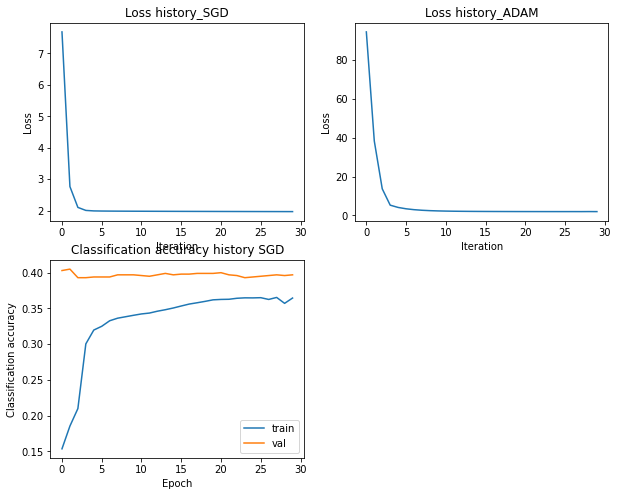

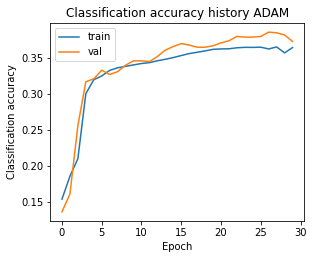

In [ ]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 2, 1)
plt.plot(train_loss_SGD)
plt.title('Loss history_SGD')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 2, 2)
plt.plot(train_loss_ADAM_)
plt.title('Loss history_ADAM')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(train_accuracy_SGD, label='train')
plt.plot(validation_SGD, label='val')
plt.title('Classification accuracy history SGD')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

plt.subplot(2, 2, 4)
plt.plot(train_accuracy_ADAM, label='train')
plt.plot(validation_ADAM, label='val')
plt.title('Classification accuracy history ADAM')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

## Hyperparameter tuning

Once you have successfully trained a network you can tune your hyparameters to increase your accuracy.

Based on the graphs of the loss function above you should be able to develop some intuition about what hyperparameter adjustments may be necessary. A very noisy loss implies that the learning rate might be too high, while a linearly decreasing loss would suggest that the learning rate may be too low. A large gap between training and validation accuracy would suggest overfitting due to large model without much regularization. No gap between training and validation accuracy would indicate low model capacity. 

You will compare networks of two and three layers using the different optimization methods you implemented. 

The different hyperparameters you can experiment with are:
- **Batch size**: We recommend you leave this at 200 initially which is the batch size we used. 
- **Number of iterations**: You can gain an intuition for how many iterations to run by checking when the validation accuracy plateaus in your train/val accuracy graph.
- **Initialization** Weight initialization is very important for neural networks. We used the initialization `W = np.random.randn(n) / sqrt(n)` where `n` is the input dimension for layer corresponding to `W`. We recommend you stick with the given initializations, but you may explore modifying these. Typical initialization practices: http://cs231n.github.io/neural-networks-2/#init
- **Learning rate**: Generally from around 1e-4 to 1e-1 is a good range to explore according to our implementation.
- **Learning rate decay**: We recommend a 0.95 decay to start.
- **Hidden layer size**: You should explore up to around 120 units per layer. For three-layer network, we fixed the two hidden layers to be the same size when obtaining the target numbers. However, you may experiment with having different size hidden layers.
- **Regularization coefficient**: We recommend trying values in the range 0 to 0.1. 

Hints:
- After getting a sense of the parameters by trying a few values yourself, you will likely want to write a few for-loops to traverse over a set of hyperparameters.
- If you find that your train loss is decreasing, but your train and val accuracy start to decrease rather than increase, your model likely started minimizing the regularization term. To prevent this you will need to decrease the regularization coefficient. 

## Run on the test set
When you are done experimenting, you should evaluate your final trained networks on the test set.

In [ ]:
#best_2layer_sgd_prediction = np.argmax(net.forward(X_test),axis = 1)
best_3layer_sgd_prediction = np.argmax(net.forward(X_test),axis = 1)
#best_2layer_adam_prediction = np.argmax(net.forward(X_test),axis = 1) 
#best_3layer_adam_prediction = np.argmax(net.forward(X_test),axis = 1) 

## Kaggle output

Once you are satisfied with your solution and test accuracy, output a file to submit your test set predictions to the Kaggle for Assignment 2 Neural Network. Use the following code to do so:

In [ ]:
#output_submission_csv('kaggle/nn_2layer_sgd_submission.csv', best_2layer_sgd_prediction)
output_submission_csv('kaggle/nn_3layer_sgd_submission.csv', best_3layer_sgd_prediction)
#output_submission_csv('kaggle/nn_2layer_adam_submission.csv', best_2layer_adam_prediction)
#output_submission_csv('kaggle/nn_3layer_adam_submission.csv', best_3layer_adam_prediction)

## Compare SGD and Adam
Create graphs to compare training loss and validation accuracy between SGD and Adam. The code is similar to the above code, but instead of comparing train and validation, we are comparing SGD and Adam.

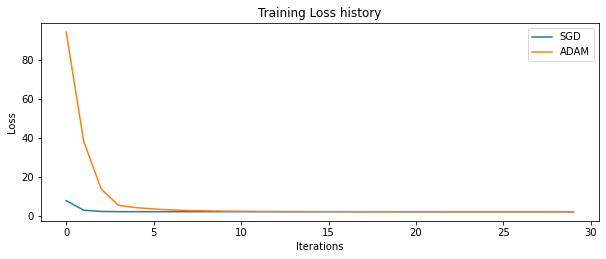

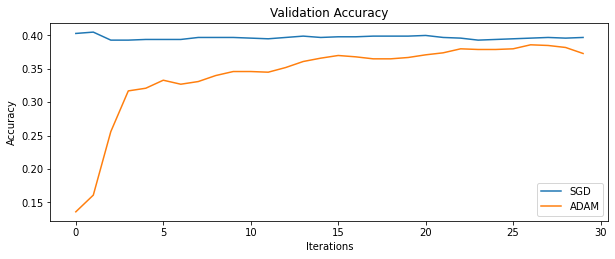

In [ ]:
# TODO: implement me
plt.subplot(2, 1, 2)
plt.plot(train_loss_SGD, label='SGD')
plt.plot(train_loss_ADAM_, label='ADAM')
plt.title('Training Loss history')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.subplot(2, 1, 2)
plt.plot(validation_SGD, label='SGD')
plt.plot(validation_ADAM, label='ADAM')
plt.title('Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()